# Adaptive PDE discretizations on cartesian grids 
## Volume : Divergence form PDEs
## Part : Static problems
## Chapter : Elliptic equations with a first order term

This notebook illustrates the use of non-negative finite difference schemes to solve elliptic partial differential equations (PDEs). More precisely, we look for a solution $u$ defined over a bounded domain $\Omega$ to the PDE
$$
    {-} \mathrm{div}(D\nabla u) + <\omega,\nabla u> + \alpha u = f,
$$
where $D$ is a field of positive definite matrices, $\omega$ is a vector field, and $\alpha$ is a non-negative scalar field. For simplicity, Dirichlet boundary conditions are applied on the boundary.

**Variational form.** The above PDE can be rephrased in variational form, by multiplication by a test function $v \in H^1_0(\Omega)$ and integration by parts. 
One is looking for the unique $u \in H^1(\Omega)$, with the prescribed Dirichlet boundary conditions, such that for any test function $v \in H^1_0(\Omega): \Omega \to R^d$ one has 
$$
    A(u,v)=0
$$
where
$$
    A(u,v) := \int_\Omega < \nabla u, D \nabla v> + <\omega, \nabla u> v + \alpha u v - f v.
$$

**Lax-Milgram theory.**
The above function $A(u,v)$ is not a bilinear form on $H^1_0(\Omega)$, for two reasons: (1) we incorporated the term $f(x) v(x)$ which is linear w.r.t.\ the test function, and (2) the unkown $u$ belongs the affine space of all functions in $H^1(\Omega)$ with the prescribed boundary conditions, instead of the linear space $H^1_0(\Omega)$. Standard mathematical techniques allow to reformulate this problem in the following canonical form: find $u \in H^1_0(\Omega)$ such that for all $v \in H^1_0(\Omega)$
$$
    B(u,v) = L(v).
$$
Under suitable assumptions, Lax-Milgram theory implies that there exists a unique solution $u$.

The presence of the non-symmetric first order term $<\omega, \nabla u> v$ in the bilinear form implies that it is not the hessian of an energy functional. The PDE therefore cannot be regarded as the optimality condition of an optimization problem, in contrast with the previous notebook [Elliptic](Elliptic.ipynb). 

**Conservative first order term**
 We also consider a variant involving a modified first order term, in divergence form
$$
     {-} \mathrm{div}(D\nabla u) - \mathrm{div}(\omega u) + \alpha u = f.
$$
The corresponding variational form
$$
    \int_\Omega < \nabla u, D \nabla v> + u <\omega, \nabla v> + \alpha u v - f v
$$
involves $u <\omega, \nabla v>$ instead of $<\omega, \nabla u> v$. This exchange of the roles of $u$ and $v$ reflects the fact that the operators $<\omega,\nabla u>$ and $- \mathrm{div}(\omega u)$ are adjoint to each other.


**Comparison with Non-Divergence form discretizations.**
One has the formal identities
$$
    \mathrm{div}(D \nabla u) = \mathrm{tr}(D \nabla^2 u) + <\mathrm{div}(D), \nabla u>.
$$
and 
$$
    \mathrm{div}(u \omega) = <\omega,\nabla u> + u \mathrm{div}(\omega).
$$
which hold for any sufficiently smooth function $u$, diffusion tensor field $D$, and vector field. For this reason, a PDE in divergence form can always be reformulated in non-divergence form.
In particular, if the diffusion tensor field $D : \Omega \to S_d^{++}$, and vector field $\omega$, are constant, then the divergence form and non-divergence for equations are formally identical. In addition the discretized linear systems coincide as well in that case, at least in the domain interior. 
And indeed, some of the test cases presented in this notebook are, purposedly, closely related with those of linear non-divergence form PDEs. 

Despite these similarities, the following differences between Divergence/non-Divergence form PDEs must be emphasized:
* The *mathematical foundations* differ strongly. Divergence form PDEs are typically studied using Lax-Milgram theory and variational forms. Non-divergence form PDEs are addressed using the machinery of degenerate elliptic operators and their viscosity solutions. 
* The *numerical implementation* differs strongly as well. The discretization of divergence form PDEs, based on their variational form, only involves first order finite differences, but requires *second order* sparse automatic differentiation (AD). On the other hand, non-divergence form PDEs are discretized using second order finite differences and *first order* sparse AD.
* *Neumann boundary conditions* are natural only for divergence form PDEs.

<!---**Variants.**
Neumann boundary conditions, on part of the boundary, can be handled as well.--->

[**Summary**](Summary.ipynb) of volume Divergence form PDEs, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. The numerical scheme](#1.-The-numerical-scheme)
  * [2. One dimensional study](#2.-One-dimensional-study)
    * [2.1 First order equation](#2.1-First-order-equation)
      * [2.1.1 Constant coefficients](#2.1.1-Constant-coefficients)
      * [2.1.2 Non-constant coefficients](#2.1.2-Non-constant-coefficients)
    * [2.2 The Laplacian operator](#2.2-The-Laplacian-operator)
      * [2.2.1 Constant coefficients](#2.2.1-Constant-coefficients)
      * [2.2.2 Variable coefficients](#2.2.2-Variable-coefficients)
    * [2.3 The vanishing viscosity limit](#2.3-The-vanishing-viscosity-limit)
  * [3. Two dimensional examples](#3.-Two-dimensional-examples)
    * [3.1 First order equation](#3.1-First-order-equation)
    * [3.2 Isotropic laplacian](#3.2-Isotropic-laplacian)
    * [3.3 Anisotropic laplacian](#3.3-Anisotropic-laplacian)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; TocTools.displayTOC('EllipticAsymmetric','Div')

In [2]:
from agd import Selling
from agd import LinearParallel as lp
from agd import FiniteDifferences as fd
from agd import AutomaticDifferentiation as ad
LInfNorm = ad.Optimization.norm_infinity

In [3]:
import numpy as np
from matplotlib import pyplot as plt

In [4]:
def weak_solution(a):
    """
    Finds u such that a(u,v)=0 for all v. 
    The two functional a should be provided as a scalar-like Sparse2.spAD2 object, 
    and should be linear w.r.t. v.
    """
    import scipy.sparse; import scipy.sparse.linalg
    n = a.bound_ad()//2
    rhs = a.to_first().to_dense(2*n).coef
    mat = scipy.sparse.coo_matrix(a.triplets()).tocsr()
    return - scipy.sparse.linalg.spsolve(mat[n:,:n],rhs[n:])

## 1. The numerical scheme

We discretize the variational form $A(u,v)$ as follows
$$
    A_h(u,v) = h^d\sum_{x \in \Omega_h} a_h(x) + b_h(x) + \alpha(x) u(x) v(x) - f(x) v(x)
$$
where $a_h(x)$ accounts for the second order term $<\nabla u(x), D \nabla v(x)>$, and $b_h(x)$ accounts for the first order term $<\omega(x),\nabla u(x)> v(x)$. The main difficulty lies in the discretization of these two terms, which is detailed below.

As usual, we denote $\Omega_h := \Omega \cap h Z^d$ the cartesian used for discretization, where $h>0$ is the grid scale.

**Selling's decomposition.**
For that purpose, we introduce a non-negative decomposition of the diffusion tensors, in the form
$$
    D(x) = \sum_{1 \leq i \leq I} \rho_i(x) e_i e_i^T,
$$
where $I = d(d+1)/2$, the weights $\rho_i(x) \geq 0$ are non-negative, and the offsets $e_i \in Z^d$ have integer coordinates. In practice $e_i = e_i(x)$ depends on the coordinate $x$, but this is silenced for readability.
If $w_0,w_1\in R^d$ are two arbitrary vectors, then
$$
    \sum_{1 \leq i \leq I} \rho_i(x) <w_0, e_i> <w_1, e_i> 
    = \mathrm{tr}(w_0 w_1^T \sum_{1 \leq i \leq I} \rho_i(x) e_i e_i^T)
    = <w_0, D(x) w_1>.
%    a_h(x) = \sum_{1 \leq i \leq I} \rho_i(x) <\nabla u(x),e_i> <\nabla v(x),e_i> + O(h) 
%    \mathrm{tr}(\sum_{1 \leq i \leq I} \rho_i(x) 
$$

**Discretization of $<\nabla u(x), D(x) \nabla v(x)>$.**
Taking advantage of the tensors decomposition, we define the non-negative scheme
$$
    a_h(x) := \frac 1 2 \sum_{1 \leq i \leq I} \sum_{\sigma\in \{-1,1\}} 
    \rho_i(x) (\frac {u(x+\sigma h e_i)-u(x)} h)( \frac {v(x+\sigma h e_i)-v(x)} h ).
$$
The consistency of $a_h(x)$ with $<\nabla u(x), D(x) \nabla v(x)>$ follows from a first order Taylor expansion, and the above expression of $<w_0,D w_1>$.

**Discretization of $<\omega(x),\nabla u(x)> v(x)$, using *centered* finite differences.**
In order to achieve second order accuracy, while preserving the non-negativity of the scheme,  we define $b_h(x)$ using finite differences along the same stencil as for $a_h(x)$. For that purpose, we introduce
$$
    \eta(x) := D(x)^{-1} \omega(x),
$$
and let 
$$
    b_h(x) := v(x)\sum_{1 \leq i \leq I} \rho_i(x) <\eta(x),e_i> (\frac {u(x+h e_i)-u(x)} h).
$$
For sufficiently small grid scales, the non-monotony of this discretization of the first order term is aborbed by the second order term. However, in some circumstances - if the grid scale isn't small, or the diffusion tensors degenerate, or the vector field is large - the monotony of global scheme can be lost, thus also its stability.

**Discretization of $<\omega(x),\nabla u(x)> v(x)$, using *upwind* finite differences.**
One can define an unconditionally stable scheme, at the price of numerical diffusion and the loss of second order accuracy, using upwind finite differences. For that purpose we let 
$$
    b_h(x) := v(x)\sum_{1 \leq i \leq d} \rho_i(x) |<\omega(x),f_i>| (\frac {u(x)-u(x- h \sigma_i f_i)} h),
%    b_h(x) := v(x)\sum_{1 \leq i \leq d} \rho_i(x) |<\omega(x),f_i>| (\frac {u(x+ h \sigma_i f_i)-u(x)} h),
$$
where $(f_i)_{i=1}^d$ is the canonical basis of $R^d$, and $\sigma_i$ denotes the sign of $<\omega(x),f_i>$.

**Dirichlet boundary conditions.**
Dirichlet boundary conditions are imposed strongly, not penalized : the values of the unkown $u$ and test function $v$ on the domain boundary are replaced with the adequate boundary condition and with zero respectively.

Nevertheless, we need to let the linear solver know that these boundary conditions are enforced, and for that purpose we also add the following term to $A_h(u,v)$:
$$
    \sum_{x \in \partial \Omega_h} (u(x)-u_0(x)) v(x),
$$
where $u_0$ denotes the imposed values on the discretized boundary $\partial \Omega_h$.

In [5]:
def Scheme(u,v,Diff,omega,alpha,f,bc,h,
           upwind=False,conservative=False):
    
    # Enforce the boundary conditions
    boundary = np.logical_not(np.isnan(bc))
    bc_integrand = (u-bc)*v 
    u,v = u.copy(),v.copy() # Important ! Avoid side effects.
    u[boundary] = bc[boundary]
    v[boundary] = 0.
    bc_integrand[np.logical_not(boundary)]=0.
    
    
    # Decompose the diffusion tensors
    coefs,offsets = (Selling.Decomposition(Diff) 
                     if Diff is not None else (np.zeros(1),np.full((len(omega),1),0)) )
    
    # Quadratic part
    dup,dum = fd.DiffUpwind(u,offsets,h),fd.DiffUpwind(u,-offsets,h) 
    dvp,dvm = fd.DiffUpwind(v,offsets,h),fd.DiffUpwind(v,-offsets,h)
    integrand2 = 0.5*((coefs*dup*dvp).sum(axis=0) + (coefs*dum*dvm).sum(axis=0))
        
    # First order part
    integrand1 = None
    U,V = (u,v) if not conservative else (v,u) # Discussed in next section
    if upwind: # Use offsets from the canonical basis
        basis = fd.as_field(np.eye(len(omega)),u.shape)
        scal = lp.dot_VV(np.expand_dims(omega,axis=1),basis)
        oriented_basis = (np.sign(scal)*basis).astype(int)
        integrand1 = -(fd.DiffUpwind(U,-oriented_basis,h)*np.abs(scal)).sum(axis=0)*V
    else: # Use offsets from the tensor decomposition, and centered differences
        eta = lp.solve_AV(Diff,omega)
        scal = lp.dot_VV(np.expand_dims(eta,axis=1),offsets)
        integrand1 = (coefs*fd.DiffCentered(U,offsets,h)*scal).sum(axis=0)*V
    
    # Zero-th order parts
    integrand0 = alpha*u*v-f*v
    
    # Summing up
    integrand = integrand0+integrand1+integrand2
    ad.simplify_ad(integrand)
    ad.simplify_ad(bc_integrand)
    return (integrand.sum()+bc_integrand.sum()) * h**u.ndim

## 2. One dimensional study

For pedagogical purposes, we first illustrate the numerical scheme in one dimension. We choose situations we illustrate a particular mathematical aspect of the scheme, by focusing on limit and/or degenerate cases, rather than some potential applications.

### 2.1 First order equation


We consider first order the PDEs, in conservative or non-conservative form
$$
    (\omega(t)u(t))'=0 \quad \text{or} \quad \omega(t)u'(t)=0
$$
for all $t\in ]-1,1[$.
The upwind scheme is used, since there is no second order diffusion operator.

We use Dirichlet boundary conditions, more precisely $u(-1)=1$ and $u(1)=0$.
These boundary conditions are incompatible in the classical sense, but thanks to the use of the upwind scheme the viscosity solution is selected. That is $u(t)= 1$ for all $t \in [0,1[$ if the coefficients are constant, and for the non-conservative form.

#### 2.1.1 Constant coefficients

The two formulations, conservative and non-conservative, are equivalent.

In [6]:
# Create the domain
X0 = np.linspace(-1,1,11)
gridScale = X0[1]-X0[0]

# Set the boundary conditions 
bc=np.full(X0.shape,np.nan)
bc[0]=1; bc[-1]=0

# Choose the PDE parameters
Diff = None; alpha = 0.; f = 0.
omega = np.array([1])

In [7]:
u=ad.Sparse2.identity(X0.shape)
v=ad.Sparse2.identity(X0.shape,shift=u.size)

In [8]:
variational = Scheme(u,v,Diff,omega,alpha,f,bc,gridScale,upwind=True,conservative=False)

The matrix of the bilinear form is diagonally dominant, which is the signature of an upwind scheme.

In [9]:
n=u.size 
variational_dense = variational.to_dense()
print("rhs: ",variational_dense.coef1[n:])
print("bilinear form:\n",variational_dense.coef2[n:,:n])

rhs:  [nan -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
bilinear form:
 [[ 0.2  0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.  -1.   1.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.  -1.   1.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.  -1.   1.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.  -1.   1.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.  -1.   1.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  -1.   1.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.  -1.   1.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.  -1.   1.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.2]]


In [10]:
variational.solve_weakform()

array([nan,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -0.])

The conservative scheme, with the correct sign convention, yieds an identical discretization and result.

In [11]:
variational = Scheme(u,v,Diff,-omega,alpha,f,bc,gridScale,upwind=True,conservative=True) # Note -(minus) omega

In [12]:
n=u.size 
variational_dense = variational.to_dense()
print("rhs: ",variational_dense.coef1[n:])
print("bilinear form:\n",variational_dense.coef2[n:,:n])

rhs:  [-0.2 -1.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
bilinear form:
 [[ 0.2  0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.  -1.   1.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.  -1.   1.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.  -1.   1.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.  -1.   1.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.  -1.   1.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  -1.   1.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.  -1.   1.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.  -1.   1.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.2]]


In [13]:
variational.solve_weakform()

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -0.])

#### 2.1.2 Non-constant coefficients

The non-conservative form of the PDE $\omega(t) u'(t)=0$ is equivalent to $u'(t)=0$, when $\omega$ is positive over the interval. In constrast, if $\omega$ is negative, then due to the upwind scheme the other boundary conditions is selected. This is consistent with the theory of viscosity solutions.

In [14]:
# Create the domain
X0 = np.linspace(-1,1,101)
gridScale = X0[1]-X0[0]

# Set the boundary conditions 
bc=np.full(X0.shape,np.nan)
bc[0]=1; bc[-1]=0

# Choose the PDE parameters
Diff = None; alpha = 0.; f = 0.
omega = np.array([1.+0.5*np.sin(2.*np.pi*X0)])

In [15]:
u=ad.Sparse2.identity(X0.shape)
v=ad.Sparse2.identity(X0.shape,shift=u.size)

In [16]:
variational = Scheme(u,v,Diff,omega,alpha,f,bc,gridScale,upwind=True,conservative=False)
variational2 = Scheme(u,v,Diff,-omega,alpha,f,bc,gridScale,upwind=True,conservative=False)

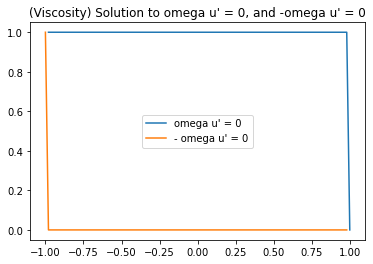

In [17]:
plt.title("(Viscosity) Solution to omega u' = 0, and -omega u' = 0")
plt.plot(X0,variational.solve_weakform(),
        X0,variational2.solve_weakform()); plt.legend(["omega u' = 0","- omega u' = 0"]);

In contrast, the solution $u$ to $(\omega u)'=0$ is non-constant. Instead, it is the flux $u'$ which is constant.

In [18]:
variational = Scheme(u,v,Diff,-omega,alpha,f,bc,gridScale,upwind=True,conservative=True)

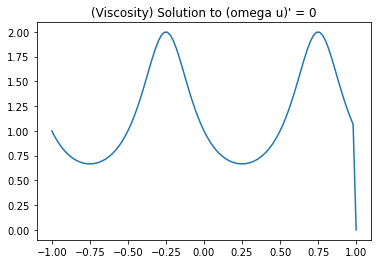

In [19]:
plt.title("(Viscosity) Solution to (omega u)' = 0")
plt.plot(X0,variational.solve_weakform());

By adjusting the scalar multiplier
$$
    (\omega u)' - \omega'u = 0,
$$
we obtain PDE with a conservative first order term and which is nevertheless equivalent to $u'=0$.

Note that the numerical solution is not perfectly constant. This is because we only use a first order scheme, and also because convergence only occurs in a weak sense. Reducing the grid scale makes the solution flatter.

**Well posedness.**
The Lax-Milgram theory requires, in principle, that the scalar coefficient $\alpha$ be non-negative. This assumption fails here, but the PDE nevertheless has a unique solution for other reasons (e.g. formulation as an ODE, or equivalence with a well posed the non-divergence form PDE).

In [20]:
alpha = -np.gradient(omega.flatten(),gridScale)
variational = Scheme(u,v,Diff,-omega,alpha,f,bc,gridScale,upwind=True,conservative=True)

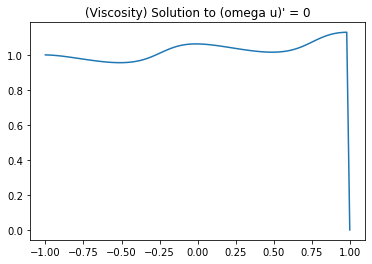

In [21]:
plt.title("(Viscosity) Solution to (omega u)' = 0")
plt.plot(X0,variational.solve_weakform());

### 2.2 The Laplacian operator

#### 2.2.1 Constant coefficients

As a starter, we solve the PDE
$$
    {-} u''(t)=0,
$$
for all $t \in ]-1,1[$. The solution which linearly interpolates between the boundary conditions, as it should.

In [22]:
# Create the domain
X0 = np.linspace(-1,1,11)
gridScale = X0[1]-X0[0]

# Set the boundary conditions 
bc=np.full(X0.shape,np.nan)
bc[0]=1; bc[-1]=0

# Choose the PDE parameters
omega = np.array([0.]); alpha = 0.; f = 0.
Diff = np.eye(1)

In [23]:
u=ad.Sparse2.identity(X0.shape)
v=ad.Sparse2.identity(X0.shape,shift=u.size)

In [24]:
variational = Scheme(u,v,Diff,omega,alpha,f,bc,gridScale)

One recognizes the tridiagonal structure of the laplacian.

In [25]:
n=u.size 
variational_dense = variational.to_dense()
print("rhs: ",variational_dense.coef1[n:])
print("bilinear form:\n",variational_dense.coef2[n:,:n])

rhs:  [nan -5.  0.  0.  0.  0.  0.  0.  0.  0. nan]
bilinear form:
 [[ 0.2  0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.  10.  -5.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.  -5.  10.  -5.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.  -5.  10.  -5.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.  -5.  10.  -5.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.  -5.  10.  -5.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.  -5.  10.  -5.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  -5.  10.  -5.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.  -5.  10.  -5.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.  -5.  10.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.2]]


<!---Upon inspection, we see that the slope is doubled in the first and last intervals $[0,h]$ and $[1-h,1]$.
That is because the discretization of the bilinear form is second order consistent with
$$
    \int_{h/2}^{1-h/2} u'(t) v'(t) \mathrm{d} t.
$$
Said otherwise, assume that an interval $[k h, (k+1) h]$ is shared by a boundary point and an interior point. 
Then, in our discretization, this interval is regarded as half boundary and half domain, and it weighs only half in the discretization of the quadratic form.--->

<!---, say $k h$, and an interior point, say $(k+1)h$. Then $[k h, (k+1/2) h]$ is regarded as part of the boundary, and $[(k+1/2) h, (k+1) h]$ is regarded as part of the domain.--->

<!---This convention may seem peculiar in dimension $1$, but it is simpler and higher order consistent for general domains in dimension $d\geq 2$.--->

In [26]:
variational.solve_weakform()

array([nan, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, nan])

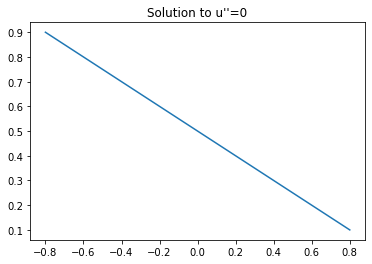

In [27]:
plt.title("Solution to u''=0")
plt.plot(X0,variational.solve_weakform());

#### 2.2.2 Variable coefficients

If the diffusion coefficients $d$ are non-constant, then the solution to 
$$
    -(d u')'=0
$$
is not affine.
This is in contrast with the non-divergence form PDEs, $-d u'' = 0$.

In [28]:
# Create the domain
X0 = np.linspace(-1,1,101)
gridScale = X0[1]-X0[0]

# Set the boundary conditions 
bc=np.full(X0.shape,np.nan)
bc[0]=1; bc[-1]=0

# Choose the PDE parameters
omega = fd.as_field(np.array([0.]),X0.shape); alpha = 0.; f = 0.
Diff = (1.+0.8*np.sin(2.*np.pi*X0)).reshape((1,1)+X0.shape)

In [29]:
u=ad.Sparse2.identity(X0.shape)
v=ad.Sparse2.identity(X0.shape,shift=u.size)

In [30]:
variational = Scheme(u,v,Diff,omega,alpha,f,bc,gridScale)

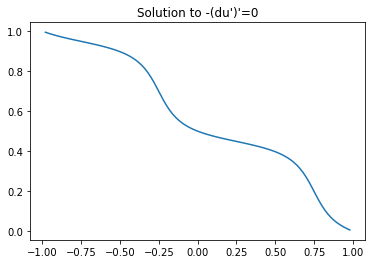

In [31]:
plt.title("Solution to -(du')'=0")
plt.plot(X0,variational.solve_weakform());

Again, one can compensate by modifying the lower order coefficients, based on the identity
$$
    -du'' = -(du')'+d'u'.
$$
Centered finite differences are used for better accuracy, and they are stable since the diffusion coefficients are positive.
<!--- = -(du')'+(d'u)'-d''u
alpha = np.gradient(np.squeeze(omega,axis=0),gridScale)
variational2 = Scheme(u,v,Diff,-omega,alpha,f,bc,gridScale,upwind=False,conservative=True)
--->

In [32]:
omega = np.gradient(np.squeeze(Diff,axis=0),gridScale,axis=1)

In [33]:
variational = Scheme(u,v,Diff,omega,alpha,f,bc,gridScale,upwind=True,conservative=False)

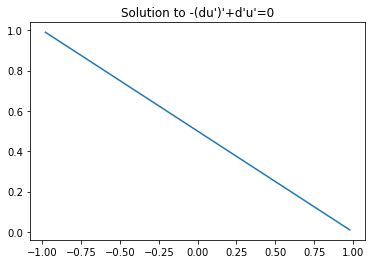

In [34]:
plt.title("Solution to -(du')'+d'u'=0")
plt.plot(X0,variational.solve_weakform());

### 2.3 The vanishing viscosity limit

We consider the PDE
$$
    -\epsilon u''(t) + u'(t) = 0
$$
for all $t \in ]-1,1[$ with again $u(0)=1$ and $u(1)=0$.
In the limit, as $\epsilon \to 0$, the viscosity solution is obtained.

Centered finite differences are used for the first order term. The numerical scheme remains stable provided $\epsilon >= h/2$.

In [35]:
# Create the domain
X0 = np.linspace(-1,1,101)
gridScale = X0[1]-X0[0]

# Set the boundary conditions 
bc=np.full(X0.shape,np.nan)
bc[0]=0; bc[-1]=1

# Choose the PDE parameters
epsilon = 2*gridScale
Diff = np.eye(1) * epsilon
alpha = 0.
omega = np.array([1])
f = 0.

In [36]:
u=ad.Sparse2.identity(X0.shape)
v=ad.Sparse2.identity(X0.shape,shift=u.size)
variational = Scheme(u,v,Diff,omega,alpha,f,bc,gridScale,upwind=False)

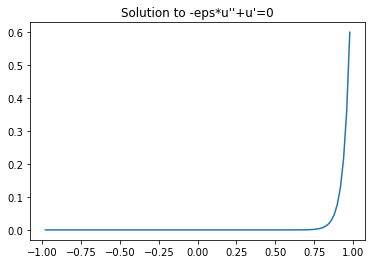

In [37]:
plt.title("Solution to -eps*u''+u'=0")
plt.plot(X0,variational.solve_weakform());

Interestingly, one recovers the upwind scheme by choosing the critical stable value $\epsilon = h/2$.

In [38]:
# Create the domain
X0 = np.linspace(-1,1,11)
gridScale = X0[1]-X0[0]

# Set the boundary conditions 
bc=np.full(X0.shape,np.nan)
bc[0]=0; bc[-1]=1

# Choose the PDE parameters
epsilon = gridScale/2
Diff = np.eye(1) * epsilon
alpha = 0.
omega = np.array([1])
f = 0.

In [39]:
u=ad.Sparse2.identity(X0.shape)
v=ad.Sparse2.identity(X0.shape,shift=u.size)
variational = Scheme(u,v,Diff,omega,alpha,f,bc,gridScale,upwind=False)

In [40]:
n=u.size 
variational_dense = variational.to_dense()
print("rhs: ",variational_dense.coef1[n:])
print("bilinear form:\n",variational_dense.coef2[n:,:n])

rhs:  [nan  0.  0.  0.  0.  0.  0.  0.  0.  0. nan]
bilinear form:
 [[ 0.2  0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.  -1.   1.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.  -1.   1.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.  -1.   1.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.  -1.   1.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.  -1.   1.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.  -1.   1.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.  -1.   1.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.  -1.   1.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.2]]


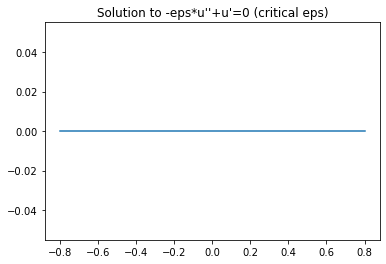

In [41]:
plt.title("Solution to -eps*u''+u'=0 (critical eps)")
plt.plot(X0,variational.solve_weakform());

## 3. Two dimensional examples

We present test cases illustrating the robustness of the scheme and various limit behaviors. For validation purposes, we reproduce some test cases from notebook [LinearMonotoneSchemes2D](../Notebooks_NonDiv/LinearMonotoneSchemes2D.ipynb).

### 3.1 First order equation

As a starter, we solve the PDE 
$$
    1 - <\omega,\nabla u> = 0,
$$
using the upwind scheme, and with formally incompatible boundary conditions. We recover, of course, the viscosity solution to the PDE

In [42]:
# Create the domain
aX0 = np.linspace(-1,1,101); aX1=aX0
gridScale = aX0[1]-aX0[0]
X0,X1 = np.meshgrid(aX0,aX1,indexing='ij')

# Set the boundary conditions 
domain = (X0**2+X1**2)<0.9**2
bc = 0.3*np.sin(2*np.pi*(X0+X1))
bc[domain] = np.nan

# Choose the PDE parameters
Diff=None; alpha=0.; f=-1.
omega = np.stack( (1.3+np.sin(np.pi*X1), np.cos(np.pi*(X0+X1)/4)) )

In [43]:
u=ad.Sparse2.identity(X0.shape)
v=ad.Sparse2.identity(X0.shape,shift=u.size)

In [44]:
# Note the sign in front of omega
variational = Scheme(u,v,Diff,-omega,alpha,f,bc,gridScale,upwind=True,conservative=False)

In [45]:
solution = variational.solve_weakform().reshape(u.shape)

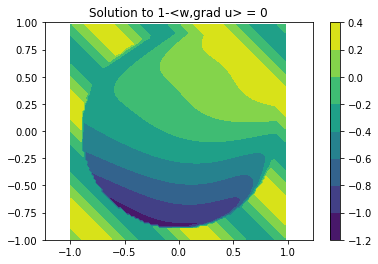

In [46]:
plt.axis('equal'); plt.title('Solution to 1-<w,grad u> = 0')
plt.contourf(X0,X1,solution); plt.colorbar();

We took care, when implementing the upwind scheme, to adapt the direction of the finite differences depending on the sign of the coefficients of the vector field $\omega$. This direction may change over the domain, as in the following example.

In [47]:
omega = np.stack( (1.3+np.sin(np.pi*X1), np.cos(np.pi*(2*X0+X1)/2)) )
variational = Scheme(u,v,Diff,-omega,alpha,f,bc,gridScale,upwind=True,conservative=False)
solution = variational.solve_weakform().reshape(u.shape)

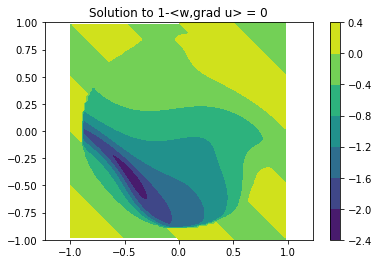

In [48]:
plt.axis('equal'); plt.title('Solution to 1-<w,grad u> = 0')
plt.contourf(X0,X1,solution); plt.colorbar();

The solution to the conservative equation 
$$
    1-\mathrm{div}(\omega u) = 0,
$$
is obviously different.
However, as in the one dimensional case, as usual we can introduce a compensating first order term.

In [49]:
variational = Scheme(u,v,Diff,omega,alpha,f,bc,gridScale,upwind=True,conservative=True) 
solution = variational.solve_weakform().reshape(u.shape)

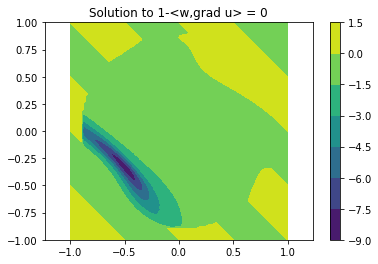

In [50]:
plt.axis('equal'); plt.title('Solution to 1-<w,grad u> = 0')
plt.contourf(X0,X1,solution); plt.colorbar();

In [51]:
div_omega = np.gradient(omega[0],gridScale,axis=0)+np.gradient(omega[1],gridScale,axis=1)

In [52]:
variational = Scheme(u,v,Diff,omega,div_omega,f,bc,gridScale,upwind=True,conservative=True) 
solution = variational.solve_weakform().reshape(u.shape)

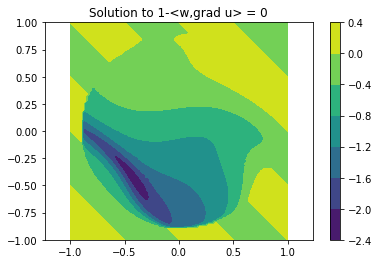

In [53]:
plt.axis('equal'); plt.title('Solution to 1-<w,grad u> = 0')
plt.contourf(X0,X1,solution); plt.colorbar();

### 3.2 Isotropic laplacian

In [54]:
# Choose the PDE parameters
diff = 1+0.8*X0
Diff = diff*fd.as_field(np.eye(2,2),X0.shape)
alpha = 1+0.8*X1
omega = fd.as_field(np.array((1.,1.)),X0.shape)
f = np.sin(4*(X0+X1))

In [55]:
variational = Scheme(u,v,Diff,omega,alpha,f,bc,gridScale,upwind=False,conservative=True)

In [56]:
solution = variational.solve_weakform().reshape(u.shape)

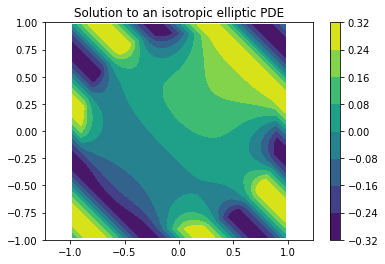

In [57]:
plt.axis('equal'); plt.title('Solution to an isotropic elliptic PDE')
plt.contourf(X0,X1,solution); plt.colorbar();

### 3.3 Anisotropic laplacian

In [58]:
ev = np.stack((1.+0.*X0, np.sin(2*np.pi*X0)), axis=0)
evNorm = np.sqrt((ev**2).sum(axis=0))
ev /= evNorm
              
Diff = 0.3**2*lp.outer_self(ev) + lp.outer_self(lp.perp(ev))

In [59]:
variational = Scheme(u,v,Diff,omega,alpha,f,bc,gridScale,upwind=False,conservative=True)

In [60]:
solution = variational.solve_weakform().reshape(u.shape)

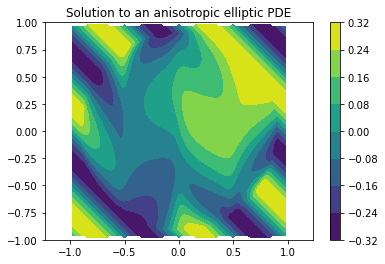

In [61]:
plt.axis('equal'); plt.title('Solution to an anisotropic elliptic PDE')
plt.contourf(X0,X1,solution); plt.colorbar();

<!---
(Unfinished work hidden here.)

## 2. Comparison with a naive scheme

We check the results using a naive discretization of the PDE, which 

def Scheme_Naive(u,Diff,omega,alpha,f,bc,h):
    """Residue for an anisotropic elliptic equation, 
    with Dirichlet boundary conditions. (Naive implementation)"""
    offsets = np.stack( ((1,0), (0,1)), axis=-1)
    du = fd.DiffCentered(u, offsets, h, padding=0)
    v = lp.dot_AV(Diff,du)
    div_v = fd.DiffCentered(v[0],(1,0),h) + fd.DiffCentered(v[1],(0,1),h)
    residue = - div_v + lp.dot_VV(omega,du) + alpha*u - f
    
    mask = np.logical_not(np.isnan(bc))
    residue[mask] = u[mask]-bc[mask]
    return ad.where(
    
    ## 3. Neumann boundary conditions
--->